In [19]:
from ecog.decoder.feature_transformation import *

import h5py
import numpy as np
import matplotlib.pyplot as plt


In [20]:
lp = '/media/ungzs10/F8426F05426EC7C8/Zsombi/MTA/ecog/data/preprocessed_data/HTNet_data/HTNet_data.hdf5'
preprocessed_data = h5py.File(lp, 'r')

train_x = preprocessed_data['train_x']
train_y = preprocessed_data['train_y']
test_x = preprocessed_data['test_x']
test_y = preprocessed_data['test_y']

subjects=list(train_x.keys())
# subjects = ['EC07']
pat_ids = {
    'EC01':'a0f66459',
    'EC02':'c95c1e82',
    'EC03':'cb46fd46',
    'EC04':'fcb01f7a',
    'EC05':'ffb52f92',
    'EC06':'b4ac1726',
    'EC07':'f3b79359',
    'EC08':'ec761078',
    'EC09':'f0bbc9a9',
    'EC10':'abdb496b',
    'EC11':'ec168864',
    'EC12':'b45e3f7b'
}

lfb = range(7,15)
hfb = range(76,101)

rest_label = 1
move_lavel = 2

In [21]:
def custom_plot(data, title):
    fig = plt.figure(figsize=(8,5))
    #fig.patch.set_facecolor('white')
    plt.imshow(data)

    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, 8, 1))
    ax.set_yticks(np.arange(0, 8, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 8+1, 1))
    ax.set_yticklabels(np.arange(1, 8+1, 1))

    # Minor ticks
    ax.set_xticks(np.arange(.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(.5, 8, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='silver', linestyle='--', linewidth=1)
    plt.title(title)
    plt.colorbar()
    plt.show()
    

subject:  EC01 

(feature vector shape) (label vector shape):  (126, 94, 946) (946,)
unique labels:  [1. 2.] 



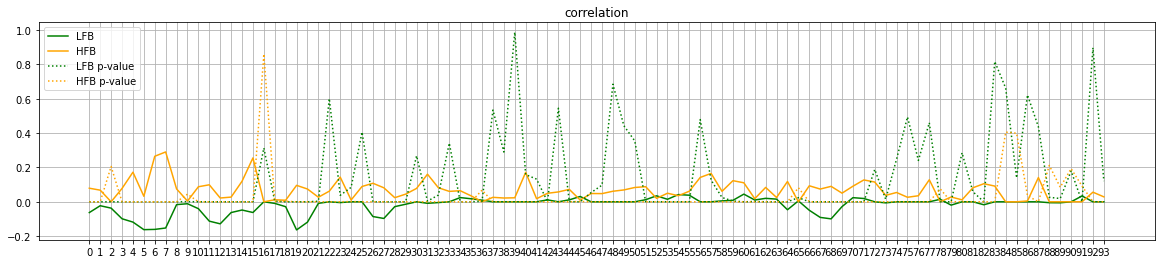

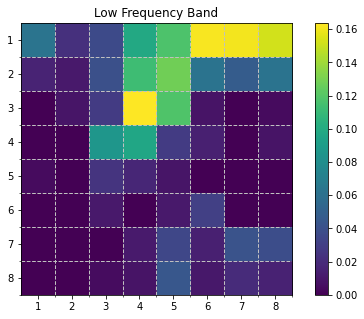

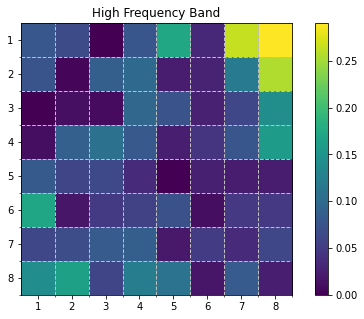

subject:  EC02 

(feature vector shape) (label vector shape):  (126, 86, 328) (328,)
unique labels:  [1. 2.] 



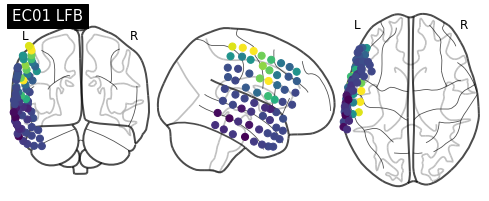

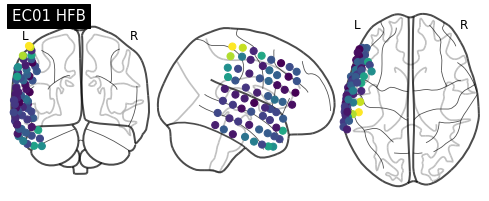

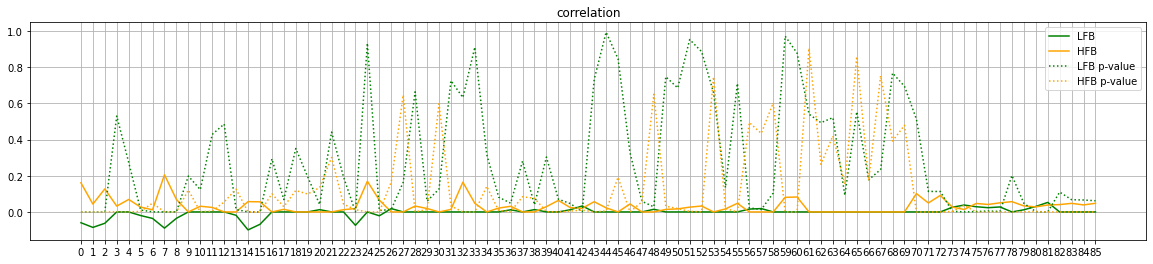

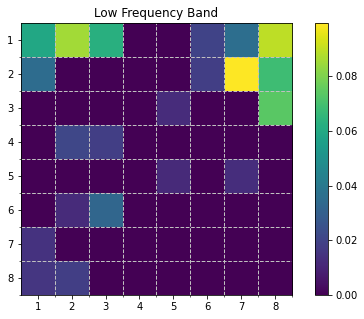

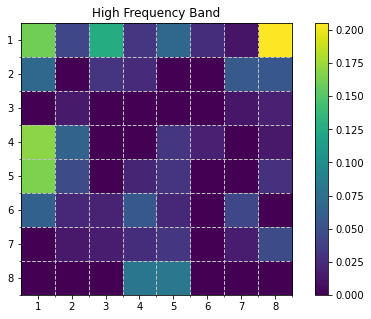

subject:  EC03 

(feature vector shape) (label vector shape):  (126, 80, 964) (964,)
unique labels:  [1. 2.] 



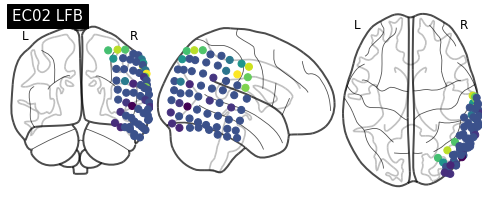

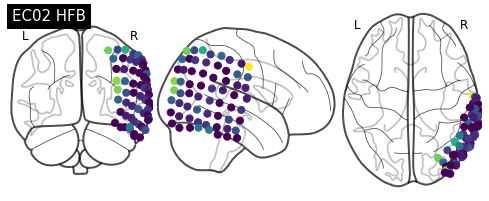

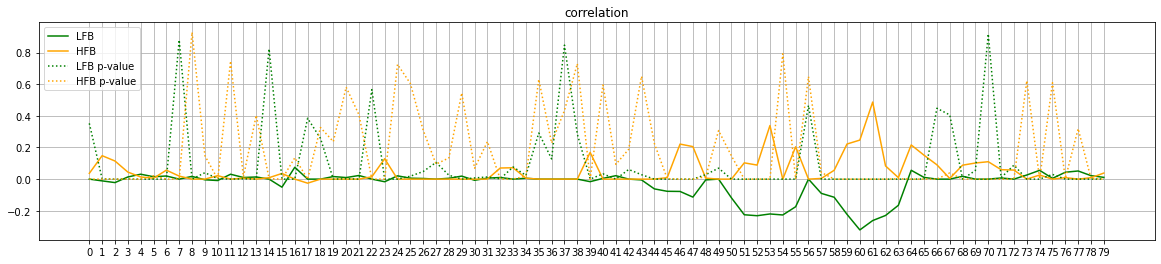

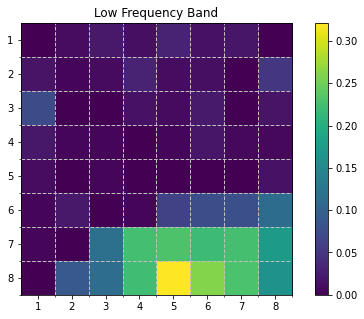

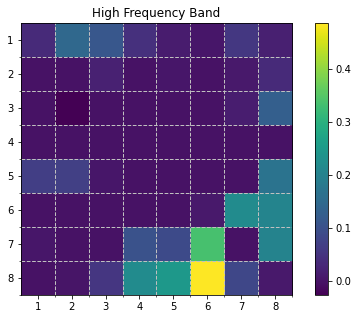

subject:  EC04 

(feature vector shape) (label vector shape):  (126, 84, 306) (306,)
unique labels:  [1. 2.] 



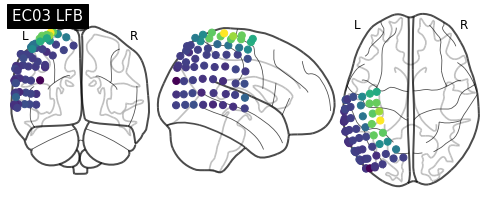

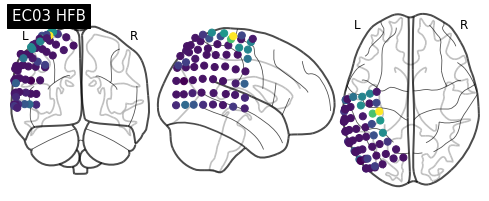

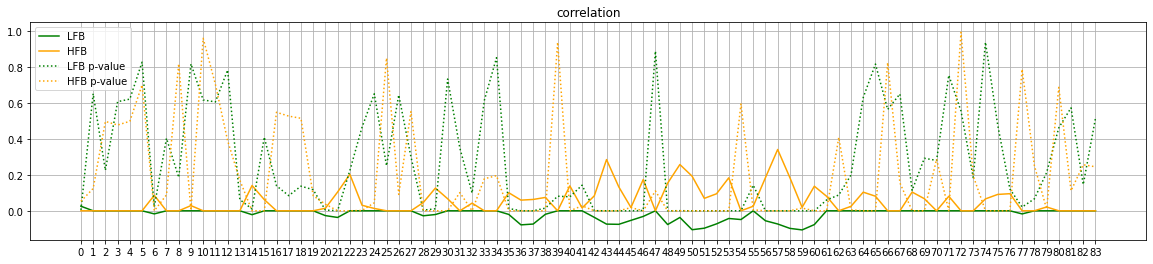

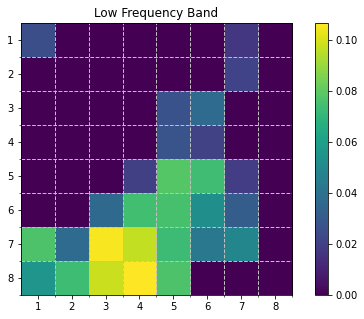

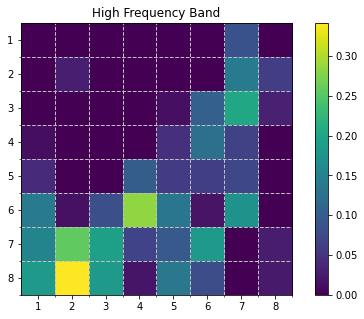

subject:  EC05 

(feature vector shape) (label vector shape):  (126, 106, 148) (148,)
unique labels:  [1. 2.] 



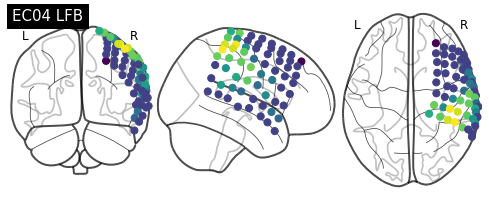

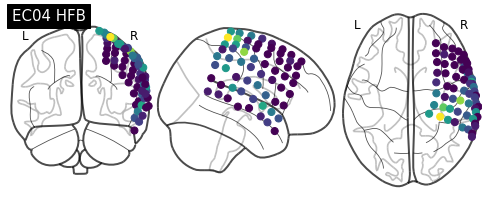

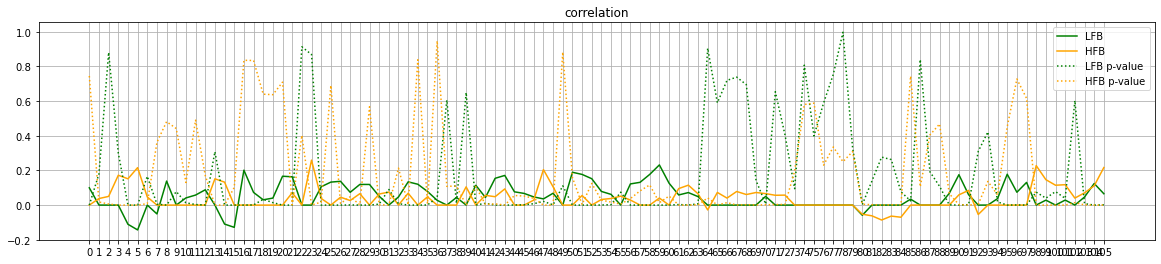

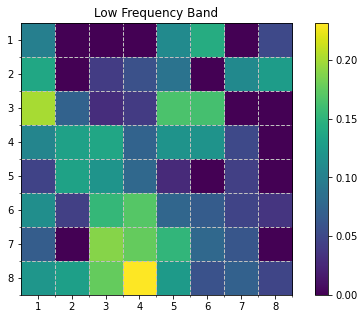

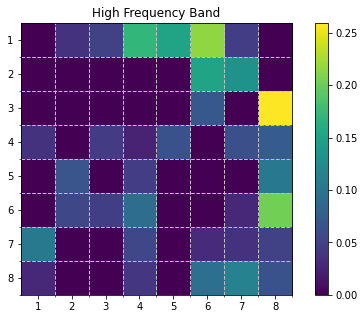

subject:  EC06 

(feature vector shape) (label vector shape):  (126, 80, 1378) (1378,)
unique labels:  [1. 2.] 



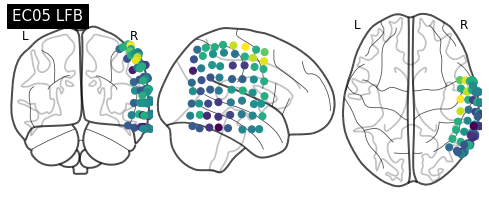

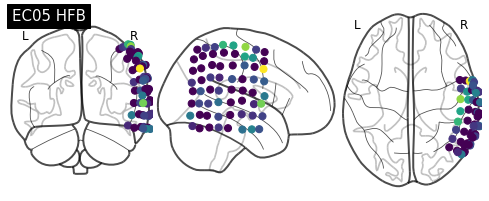

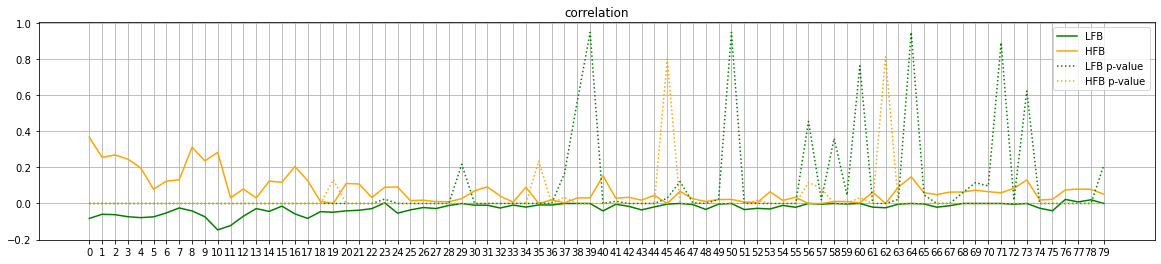

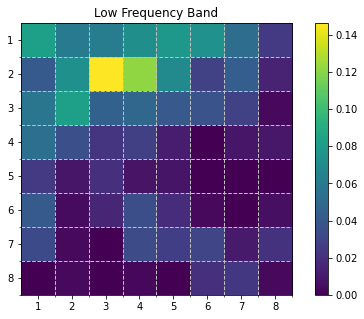

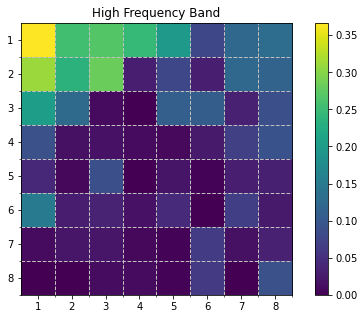

subject:  EC07 

(feature vector shape) (label vector shape):  (126, 64, 1004) (1004,)
unique labels:  [1. 2.] 



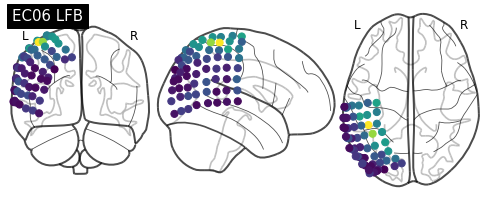

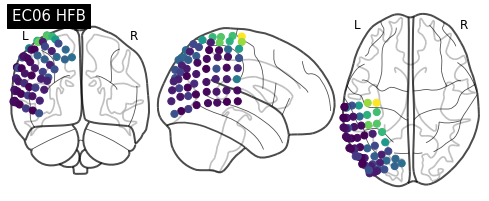

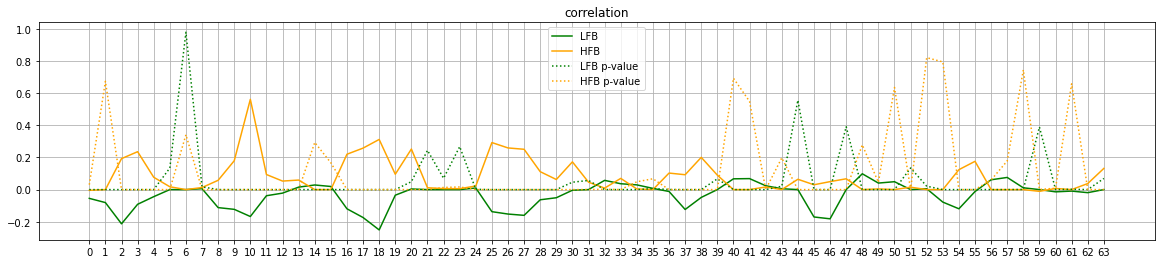

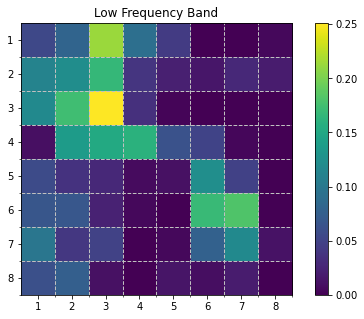

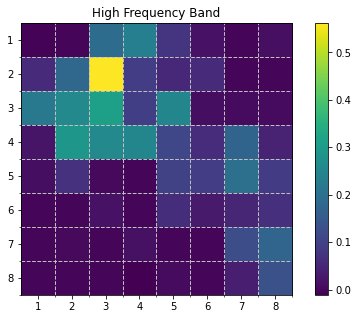

subject:  EC08 

(feature vector shape) (label vector shape):  (126, 92, 1344) (1344,)
unique labels:  [1. 2.] 



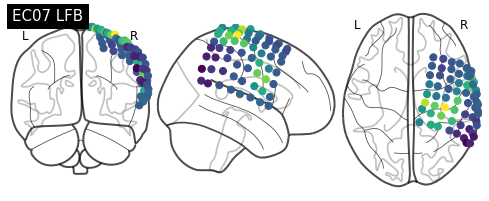

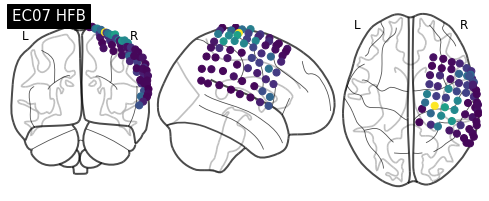

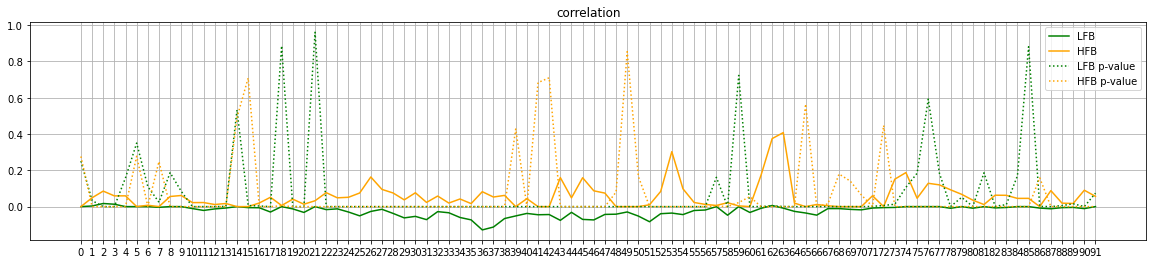

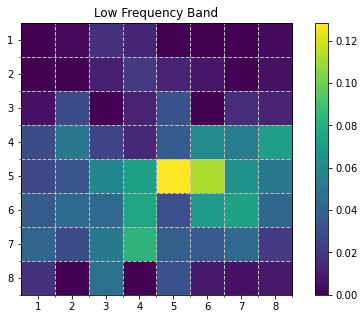

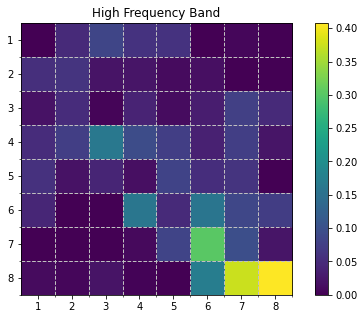

subject:  EC09 

(feature vector shape) (label vector shape):  (126, 126, 260) (260,)
unique labels:  [1. 2.] 



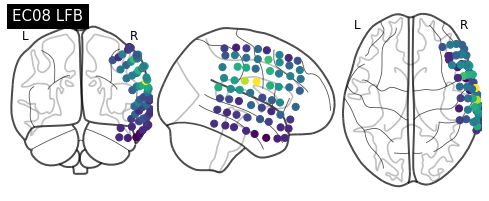

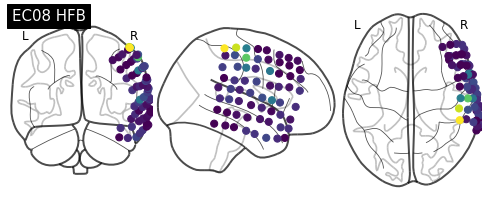

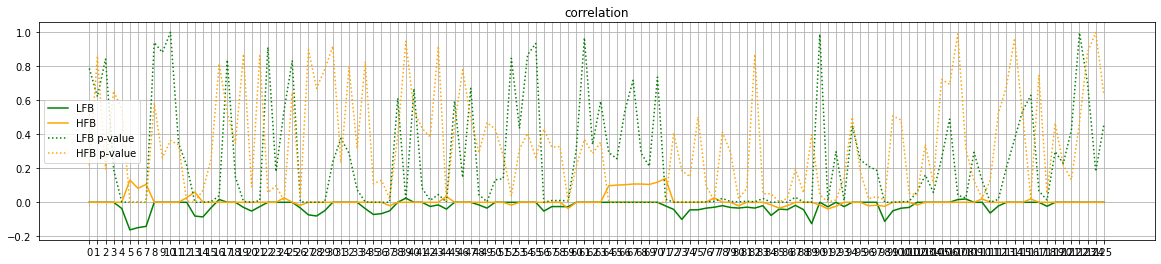

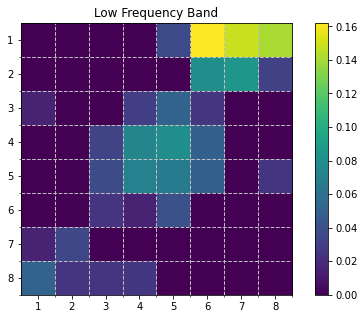

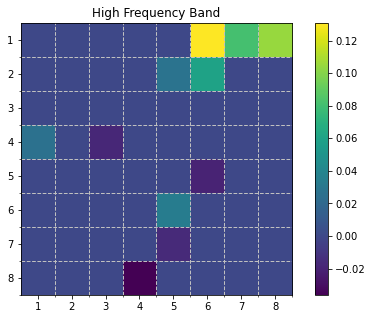

subject:  EC10 

(feature vector shape) (label vector shape):  (126, 126, 932) (932,)
unique labels:  [1. 2.] 



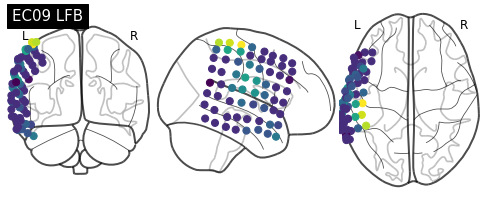

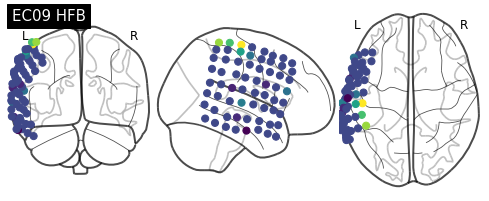

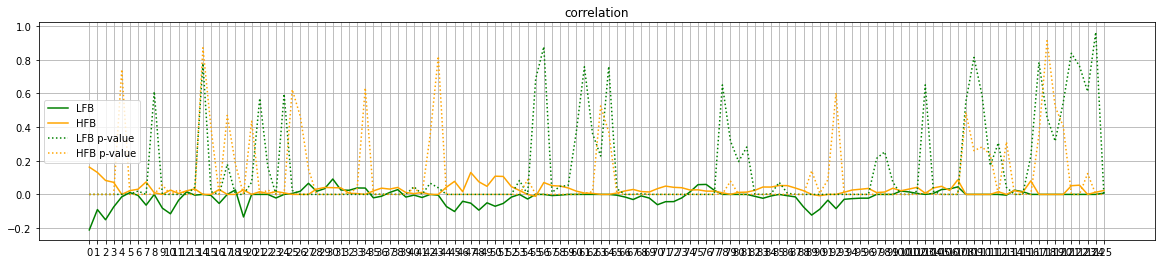

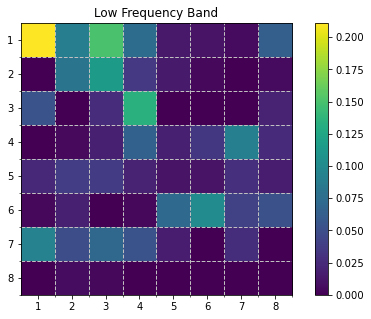

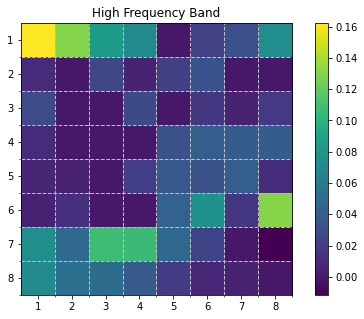

subject:  EC11 

(feature vector shape) (label vector shape):  (126, 106, 1424) (1424,)
unique labels:  [1. 2.] 



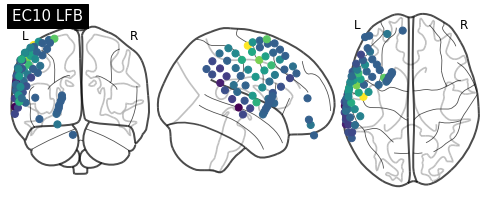

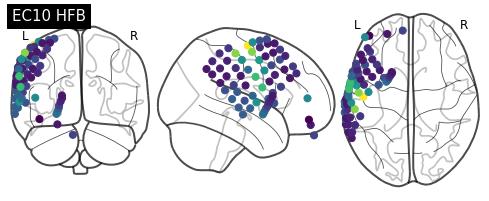

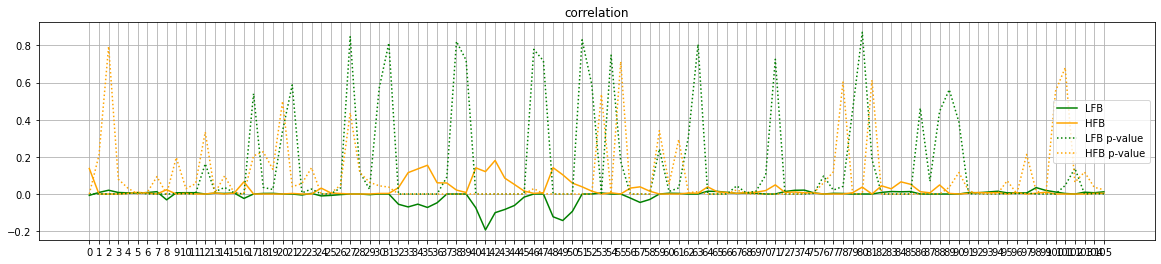

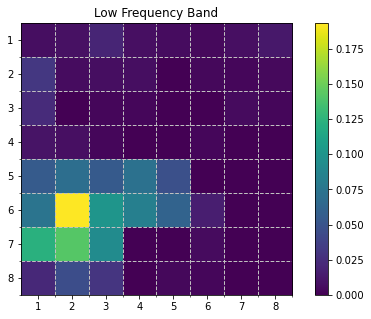

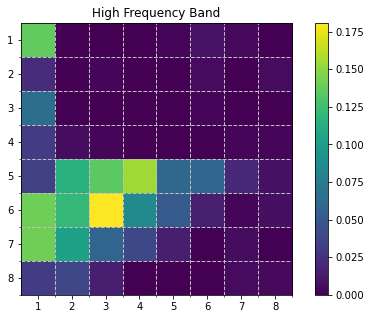

subject:  EC12 

(feature vector shape) (label vector shape):  (126, 116, 1512) (1512,)
unique labels:  [1. 2.] 



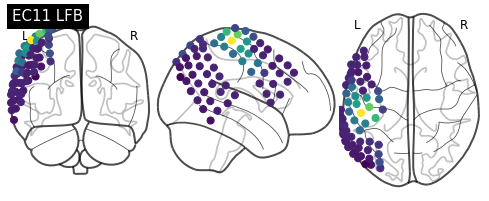

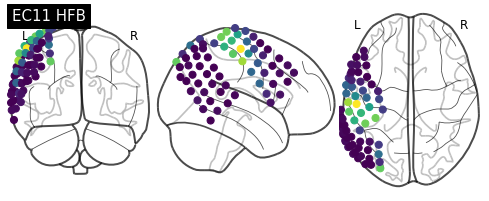

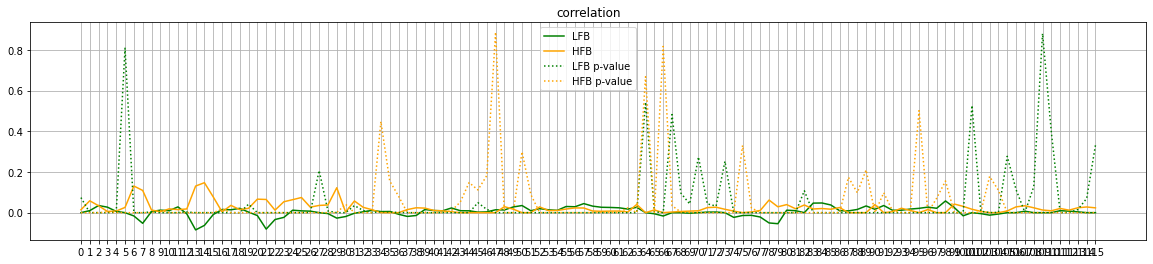

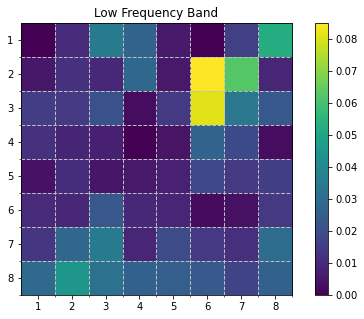

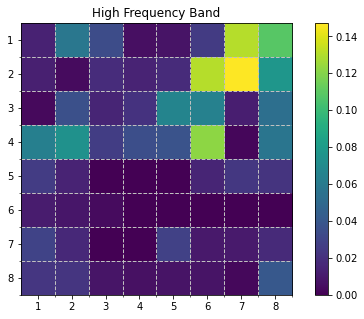

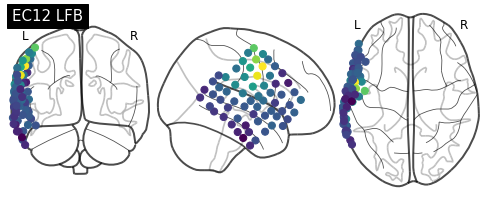

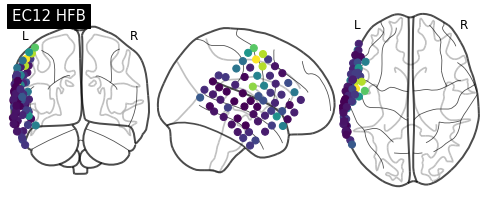

In [22]:
import pandas as pd
import nilearn.plotting as nl

for i, name in enumerate(subjects):
    print('subject: ', subjects[i], '\n')

    px = np.asarray(train_x[name])
    px = np.transpose(px, axes=[2,1,0])
    py = np.asarray(train_y[name])
    print('(feature vector shape) (label vector shape): ', px.shape, py.shape)
    print('unique labels: ', np.unique(py), '\n')

    ## Normalize data & isolate HFB and LFB

    num_chans = px.shape[1]
    num_trials = px.shape[2]

    px_mean = np.mean(px, axis=2)

    ## Isolate HFB and LFB,

    px_temp = np.divide(px, np.dstack([px_mean]*num_trials))  # normalize data:every datapoint is divided by the average power of the same freq at the same channel
    lfb_trials = squeeze(sum(px_temp[lfb,:,:],0))
    hfb_trials = squeeze(sum(px_temp[hfb,:,:],0))

    ## Comparisons - signed r-squared and unpaired t-test
    #hand=hand v rest, tongue=tongue v rest; r = signed square cross correlation, p=p-value from paired t-test

    r_LFB = []; r_HFB = []
    p_LFB = []; p_HFB = []

    for ch in range(num_chans):
        # extract rest data
        LFB_m1 = lfb_trials[ch, np.where(py == 1)]
        HFB_m1 = hfb_trials[ch, np.where(py == 1)]

        # extract move data
        LFB_1 = lfb_trials[ch, np.where(py == 2)]
        HFB_1 = hfb_trials[ch, np.where(py == 2)]

        # calculate r-squared cross correlation
        r_LFB.append(rsa(LFB_1, LFB_m1))
        r_HFB.append(rsa(HFB_1, HFB_m1))

        # calculate p-value of t-test
        p_LFB.append(float(ttest_ind(LFB_1, LFB_m1, 1)[1]))
        p_HFB.append(float(ttest_ind(HFB_1, HFB_m1, 1)[1]))

    # 'we included only electrodes with changes in power significant at the 0.05 Bonferroni-corrected level'
    r_LFB = np.where(np.asarray(p_LFB)<0.05 , r_LFB, 0)
    r_HFB = np.where(np.asarray(p_HFB)<0.05 , r_HFB, 0)

    # plot correlation
    fig = plt.figure(figsize=[20,4])
    ax = fig.gca()
    ax.set_xticks(np.arange(0, len(r_LFB), 1))
    ax.plot(r_LFB, label='LFB', color='g')
    ax.plot(r_HFB,label='HFB', color='orange')
    ax.plot(p_LFB, label='LFB p-value', color='g', linestyle='dotted')
    ax.plot(p_HFB,label='HFB p-value', color='orange', linestyle='dotted')
    plt.grid()
    plt.legend()
    plt.title('correlation')
    plt.show()

    r_LFB_temp = np.asarray(r_LFB[:64]).reshape(8, 8)
    r_HFB_temp = np.asarray(r_HFB[:64]).reshape(8, 8)

    custom_plot(np.abs(r_LFB_temp), 'Low Frequency Band')
    custom_plot(r_HFB_temp, 'High Frequency Band')

    # plot on brain
    file = '/media/ungzs10/F8426F05426EC7C8/Zsombi/MTA/ecog/data/raw_data/naturalistic_move_v_rest/electrode_locations/ecog_metadata_{}.csv'.format(pat_ids[name])
    df = pd.read_csv(file)
    ch_names = df['Unnamed: 0'].values.tolist()
    elec = np.asarray([[x,y,z] for x,y,z in zip(df['X'], df['Y'], df['Z'])])
    elec = elec[:64,:]

    weights = [-1*x for x in r_LFB]
    #norm = np.linalg.norm(weights)
    #weights_norm = weights/norm
    color = [[w, 0, 0, 1] for w in weights]

    nl.plot_connectome(adjacency_matrix=np.eye(elec.shape[0]),
                       node_coords=elec,
                       node_color=weights[:64],
                       title=name+' LFB')

    weights = r_HFB
    #norm = np.linalg.norm(weights)
    #weights_norm = weights/norm
    color = [[w, 0, 0, 1] for w in weights]

    nl.plot_connectome(adjacency_matrix=np.eye(elec.shape[0]),
                       node_coords=elec,
                       node_color=weights[:64],
                       title=name + ' HFB',
                       annotate=True)
